In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/데이터분석_프로젝트/ai_factory/data_set/

/content/drive/MyDrive/데이터분석_프로젝트/ai_factory/data_set


In [61]:
import pandas as pd

from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout, BatchNormalization,  Activation
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics

In [ ]:
from sklearn.preprocessing import StandardScaler

In [39]:
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 154.1 KB


In [6]:
train_df.shape, test_df.shape

((2463, 8), (7389, 8))

In [80]:
def type_converter(x) :
    if x == 0 or x == 4 or x == 5  or x == 6 or x == 7 :
        x = 30
    elif x == 1 :
        x = 20
    elif x == 2 :
        x = 10
    elif x == 3 :
        x = 50
    return x

In [81]:
train_df["HP"] = train_df["type"].apply(type_converter) 

In [82]:
test_df["HP"] = test_df["type"].apply(type_converter) 

In [83]:
train_df

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,HP
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0,30
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0,30
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0,30
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0,30
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0,30
...,...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7,30
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7,30
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7,30
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7,30


In [11]:
#train_df = pd.get_dummies(train_df, columns = ["type"])

In [12]:
#test_df = pd.get_dummies(test_df, columns = ["type"])

In [13]:
train_df.isnull().sum()

air_inflow       0
air_end_temp     0
out_pressure     0
motor_current    0
motor_rpm        0
motor_temp       0
motor_vibe       0
type             0
HP               0
dtype: int64

In [14]:
train_df["type"].value_counts()

0    432
1    369
2    366
3    306
4    306
5    249
6    249
7    186
Name: type, dtype: int64

In [112]:
# from keras import regularizers

def dnn(x):
    input_dim = x.shape[1]
    input = Input(shape=(input_dim, ))
    
    #encode = Dense(64, activation = "relu")(input)
    encode = Dense(64)(input)
    encode = BatchNormalization()(encode)
    encode = Activation('relu')(encode)

    ##encode = Dense(32, activation = "relu")(encode)
    encode = Dense(32)(encode)
    encode = BatchNormalization()(encode)
    encode = Activation('relu')(encode)

    #decode = Dense(64, activation = "relu")(encode)
    decode = Dense(64)(encode)
    decode = BatchNormalization()(decode)
    decode = Activation('relu')(decode)

    #output = Dense(input_dim, activation='linear')(decode)
    output = Dense(input_dim)(decode)
    output = BatchNormalization()(output)
    output = Activation('linear')(output)

    autoencoder = Model(input, output)

    autoencoder.summary()
    
    return autoencoder

In [ ]:
model = dnn(train_df_scaled)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 9)]               0         
                                                                 
 dense_53 (Dense)            (None, 64)                640       
                                                                 
 batch_normalization_31 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_32 (Bat  (None, 32)               128       
 chNormalization)                                         

In [113]:
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)

In [108]:
def lrfn(epoch):
    # 내포 함수인 calc_fn()에서 사용되는 파라미터. 
    LR_START = 1e-5
    LR_MAX = 1e-3
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 2
    LR_STEP_DECAY = 0.75
    
    def calc_fn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//2)
        return lr
    
    # 반드시 내포 함수인 calc_fn(epoch)를 호출해야함. 
    return calc_fn(epoch)

In [109]:
model.compile(optimizer= "Adam", loss= 'mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10,  restore_best_weights=True)
lr_cb = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [110]:
epochs = 1000
batch = 8

In [111]:
history = model.fit(train_df_scaled, train_df_scaled, epochs=epochs, batch_size=batch, validation_split=0.1, callbacks=[early_stopping, lr_cb])


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/1000
277/277 [==============================] - 3s 4ms/step - loss: 2.1169 - val_loss: 0.8906 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 0.000208.
Epoch 2/1000
277/277 [==============================] - 1s 5ms/step - loss: 0.8885 - val_loss: 0.4697 - lr: 2.0800e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000406.
Epoch 3/1000
277/277 [==============================] - 1s 4ms/step - loss: 0.4442 - val_loss: 0.1496 - lr: 4.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0006039999999999999.
Epoch 4/1000
277/277 [==============================] - 1s 4ms/step - loss: 0.3658 - val_loss: 0.0904 - lr: 6.0400e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000802.
Epoch 5/1000
277/277 [==============================] - 1s 3ms/step - loss: 0.3222 - val_loss: 0.0482 - lr: 8.0200e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0

In [102]:
min(history.history['val_loss'])

0.010949318297207355

In [ ]:
#1. 9.835202217800543e-05(0.00010687271076630244882) none feature, batch, lrd
#2. 0.013271326199173927 none feaure, lrd
#3. 0.009297532960772514 none feature
#4. 0.00016894080908969045 nonr batch
#5. 8.891143806977198e-05(0.000017997485266252692945) none batch, lrd
#6. 0.000027005475944783841948 none bactch
#7. 0.010949318297207355 full

In [51]:
import matplotlib.pyplot as plt

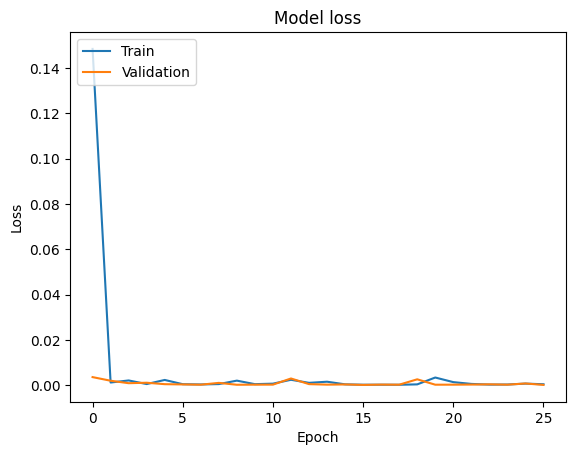

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_df_reconstructed =  model.predict(test_df_scaled)

231/231 [==============================] - 0s 1ms/step


In [ ]:
reconstruction_error = np.mean(np.square(test_df_scaled - test_df_reconstructed), axis=1)

In [ ]:
threshold = np.percentile(reconstruction_error, 95)

In [ ]:
test_predictions = (reconstruction_error > threshold).astype(int)

In [ ]:
from collections import Counter

# Count the number of 0s and 1s in y_pred_binary
count = Counter(test_predictions)
num_0 = count[0]
num_1 = count[1]

print("Number of 0s: ", num_0)
print("Number of 1s: ", num_1)

Number of 0s:  7019
Number of 1s:  370


In [ ]:
pd.DataFrame(test_predictions)

,0
0,0
1,0
2,0
3,0
4,0
...,...
7384,0
7385,1
7386,1
7387,1


In [ ]:
sub = pd.read_csv("answer_sample.csv")

In [ ]:
sub["label"] = test_predictions

In [ ]:
sub

,type,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
7384,7,0
7385,7,1
7386,7,1
7387,7,1


In [ ]:
sub.to_csv("test_first.csv")

## 다른 코드